# Predicting demand likelihood on Avito's classified advertisements

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn import preprocessing, utils
from sklearn.svm import SVC,SVR
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB

In [2]:
df_train = pd.read_csv('train.csv.zip', compression='zip')
#print(df_train.shape)
#df_train.head(2)

In [3]:
df_test= pd.read_csv('test.csv.zip', compression='zip')
#print(df_test.shape)
#df_test.head(2)

In [4]:
number_of_ads=df_train.shape[0]
round(df_train.isnull().sum()*100/number_of_ads,2)

item_id                  0.00
user_id                  0.00
region                   0.00
city                     0.00
parent_category_name     0.00
category_name            0.00
param_1                  4.10
param_2                 43.54
param_3                 57.37
title                    0.00
description              7.73
price                    5.68
item_seq_number          0.00
activation_date          0.00
user_type                0.00
image                    7.49
image_top_1              7.49
deal_probability         0.00
dtype: float64

In [5]:
#Eliminar NaN nas colunas dos anúnicos. Aqui usamos apenas a coluna 'price'
df_train_=df_train
df_train_[['price']]=df_train_[['price']].fillna(0.0)
#round(df_train.isnull().sum()*100/number_of_ads,2)

## Explorando os dados 

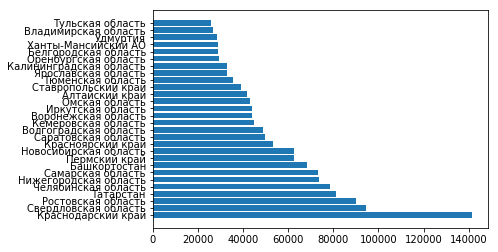

In [6]:
#Regios e seus numeros de anúncios
region_ads_number= df_train['region'].value_counts()
#Guardar os nomes das regiões
regions_names = np.array(region_ads_number.index)
#Guardar os números de anuncios por região.
ads_numbers= np.array(region_ads_number)
#Criar um dataframe com as informações anterios
df_region_ads = pd.DataFrame({'region': regions_names, 'number of ads': ads_numbers})
rank = np.arange(0, len(df_region_ads))
plt.barh(rank, df_region_ads['number of ads'])
plt.yticks(rank, df_region_ads['region'])
plt.show()

In [7]:
#df_train[['category_name','price','deal_probability']].groupby('category_name').describe()
#df_train[['category_name','deal_probability']].groupby('category_name').describe()
#Probabilidade média por categoria
company_mean_grp=df_train[['category_name','deal_probability']].groupby('category_name').mean()

In [8]:
#Colocamos as categoria e suas probabilidades médias em um dicionário
dic_categories={}

for row in company_mean_grp.itertuples():
    #Formato ('category_name', deal_probability)
    str1=str(row[0]) 
    #Remover parenteses
    str2=str1.replace('(','')
    str3=str2.replace(')','')
    #Particionar em tokens separados por uma virgula: ,
    str4=str3.split(',')
    #Primeiro token é category_name
    category=str4[0]
    #Probabilidade é mais simples de extrair
    deal_probability=row.deal_probability
    #print(category, ' ',deal_probability) #Para teste
    dic_categories[category]=deal_probability
#dic_categories #Para teste

In [9]:
#Retorna a probabilidade média da categoria
def setCategoryProb(row):
    key=str(row['category_name'])
    prob=0.0
    if key in dic_categories.keys():
        prob=dic_categories[key]
    return prob

In [10]:
df_train['category_prob']=df_train.apply(setCategoryProb, axis=1)

In [11]:
df_train[['category_name', 'category_prob']].head(5)

,category_name,category_prob
0,Товары для детей и игрушки,0.198445
1,Мебель и интерьер,0.191848
2,Аудио и видео,0.171572
3,Товары для детей и игрушки,0.198445
4,Автомобили,0.278427


In [12]:
df_train[['user_type','deal_probability']].groupby('user_type').count()/df_train.shape[0]

,deal_probability
user_type,
Company,0.230972
Private,0.715504
Shop,0.053524


In [13]:
df_train[['user_type','deal_probability']].groupby('user_type').mean()

,deal_probability
user_type,
Company,0.124513
Private,0.149557
Shop,0.062829


In [14]:
def setUserProb(row):
    mean_prob=0.0
    user_type=str(row['user_type'])
    if user_type=="Shop":
        mean_prob=0.062829
    elif user_type=="Private":
        mean_prob=0.149557
    elif user_type=="Company":
        mean_prob=0.124513
    return mean_prob

In [15]:
def setUserProp(row):
    prop=0.0
    user_type=str(row['user_type'])
    if user_type=="Shop":
        prop=0.053524
    elif user_type=="Private":
        prop=0.715504
    elif user_type=="Company":
        prop=0.230972
    return prop

In [16]:
df_train['user_type_freq']=df_train.apply(setUserProp, axis=1)
df_train['user_type_prob']=df_train.apply(setUserProb, axis=1)

In [17]:
df_train[['user_type','user_type_freq', 'user_type_prob']].head(12)

,user_type,company_prop,company_prob
0,Private,0.715504,0.149557
1,Private,0.715504,0.149557
2,Private,0.715504,0.149557
3,Company,0.230972,0.124513
4,Private,0.715504,0.149557
5,Private,0.715504,0.149557
6,Private,0.715504,0.149557
7,Private,0.715504,0.149557
8,Private,0.715504,0.149557
9,Company,0.230972,0.124513


In [18]:
df_train_=df_train[['user_type_freq', 'user_type_prob', 'category_prob', 'price','deal_probability']]

In [19]:
df_train_.head()

,company_prop,company_prob,category_prob,price,deal_probability
0,0.715504,0.149557,0.198445,400.0,0.12789
1,0.715504,0.149557,0.191848,3000.0,0.00000
2,0.715504,0.149557,0.171572,4000.0,0.43177
3,0.230972,0.124513,0.198445,2200.0,0.80323
4,0.715504,0.149557,0.278427,40000.0,0.20797


Histograma das probabilidades

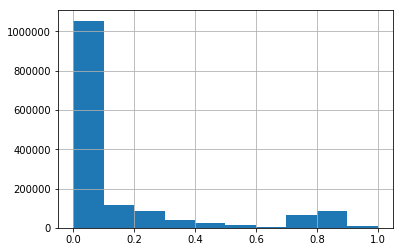

In [20]:
df_train['deal_probability'].hist()

Categorizar as probabilidades

In [21]:
#Qualidade alta
df_train_A=df_train.query("deal_probability>=0.67") 
#Qualidade Media 
df_train_M=df_train.query("deal_probability>=0.33 and deal_probability<0.67") 
#Qualidade Baixa 
df_train_B=df_train.query("deal_probability<0.33") 

df_train_MB25=df_train.query("deal_probability<0.25") 
df_train_MB15=df_train.query("deal_probability<0.15") 

print('Qde de rows Qualidade alta.........:',len(df_train_A.index))
print('Qde de rows Qualidade Media........:',len(df_train_M.index))
print('Qde de rows Qualidade baixa..:', len(df_train_B.index))
print('Qde de rows Qualidade muito baixa 0.15..:', len(df_train_MB15.index))
print('Qde de rows Qualidade muito baixa 0.25..:', len(df_train_MB25.index))

number_of_ads=df_train.shape[0]
number_of_ads==len(df_train_A.index)+len(df_train_M.index)+len(df_train_B.index)

Qde de rows Qualidade alta.........: 164795
Qde de rows Qualidade Media........: 68478
Qde de rows Qualidade baixa..: 1270151
Qde de rows Qualidade muito baixa 0.15..: 1126907
Qde de rows Qualidade muito baixa 0.25..: 1220441


True

In [22]:
#Considera-se 3 categorias
perc_A=len(df_train_A.index)/number_of_ads
perc_M=len(df_train_M.index)/number_of_ads
perc_B=len(df_train_MB15.index)/number_of_ads
print(perc_A, '-',perc_M,'-', perc_B)

0.10961312311097868 - 0.04554802903239539 - 0.7495603369375505


Extraction of 60.000 rows for trains and 20000 for tests

In [23]:
sample_size=60000
train_sample_size=40000
test_sample_size=20000
A_sample_size=int(perc_A*sample_size)
M_sample_size=int(perc_M*sample_size)
B_sample_size=sample_size-(A_sample_size+M_sample_size)
print('A size:', A_sample_size, '- M size: ', M_sample_size, '- B size : ',B_sample_size)

A size: 6576 - M size:  2732 - B size :  50692


In [24]:
import random

#Extrair amostra de cada categoria
df_A=df_train_A.sample(n=A_sample_size, random_state=random.randint(1,A_sample_size))
df_M=df_train_M.sample(n=M_sample_size, random_state=random.randint(1,M_sample_size))
df_B=df_train_B.sample(n=B_sample_size, random_state=random.randint(1,B_sample_size))

#Renomeamos
df_A_=df_A
df_M_=df_M
df_B_=df_B

print('A: ', df_A.shape, 'B: ', df_M.shape,' C:', df_B.shape)

A:  (6576, 21) B:  (2732, 21)  C: (50692, 21)


Unir os conjunto de anúncios em df

In [25]:
df_sample=pd.concat([df_A_, df_M_, df_B_], axis=0)
print('sample size and test size :', df_sample.shape)

sample size and test size : (60000, 21)


#### Features extraction
Only numeric data

In [26]:
df_sample[['user_type_freq', 'user_type_prob', 'category_prob', 'price', 'deal_probability']].head()

,company_prop,company_prob,category_prob,price,deal_probability
1486583,0.715504,0.149557,0.060834,399.0,0.80323
965470,0.715504,0.149557,0.000000,399.0,0.80323
745292,0.230972,0.124513,0.000000,1000.0,0.80323
1316057,0.715504,0.149557,0.198445,1500.0,0.80323
824238,0.230972,0.124513,0.060834,100.0,0.80323


In [27]:
X=df_sample[['user_type_freq', 'user_type_prob', 'category_prob', 'price']].values
print(X.shape)
X[:5]

(60000, 4)


array([[7.15504000e-01, 1.49557000e-01, 6.08343758e-02, 3.99000000e+02],
       [7.15504000e-01, 1.49557000e-01, 0.00000000e+00, 3.99000000e+02],
       [2.30972000e-01, 1.24513000e-01, 0.00000000e+00, 1.00000000e+03],
       [7.15504000e-01, 1.49557000e-01, 1.98445425e-01, 1.50000000e+03],
       [2.30972000e-01, 1.24513000e-01, 6.08343758e-02, 1.00000000e+02]])

In [28]:
y=df_sample['deal_probability'].values 
y[:5]

array([0.80323, 0.80323, 0.80323, 0.80323, 0.80323])

Extraimos parte das features e target para o treinamento. E outra parte para os testes

In [29]:
n=train_sample_size #n=32
#features and targets for trains
X_train=X[:n]
y_train=y[:n]
#features and targets for tests
X_test=X[n:]
y_test=y[n:]

### 1. Previsão usando regressão com SVR

In [30]:
clf=None
clf = SVR() 
clf.fit(X_train, y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [31]:
y_hat=clf.predict(X_test)

Vamos calcular o erro da previsão com variancia e desvio padrão.

In [32]:
#Função auxiliar usada para avaliar as técnicas
#Calcular a variancia de qualquer probalidade estimada
def setVariance(row):
    """
    Entrada:
        row:tupla de dataframe
    Saída:
        variancia:float
    """
    return (row['predicted_deal_probality']-row['expected_deal_probality'])**2

* Criar dataframe com as demandas/probabilidades previstas e as estimadas pelo classificador
* Aplicar a função em cada tupla para obter a variancia da probabilidade estimada.
* calcular a variancia e desvio padrão considerando a media da amostra. 
* Desvio está baixo?

In [33]:
#AVALIAR
df_proba = pd.DataFrame({'expected_deal_probality': y_test,
                         'predicted_deal_probality': y_hat})
#Cria-se uma nova coluna no df
df_proba['desvio'] = df_proba.apply(setVariance, axis=1)
std=np.sqrt(df_proba[['desvio']].sum()/len(df_proba.index))
print('Desvio baixo? ', std)
df_proba.head()

Desvio baixo?  desvio    0.123915
dtype: float64


,expected_deal_probality,predicted_deal_probality,desvio
0,0.00000,0.177400,0.031471
1,0.00000,0.131733,0.017353
2,0.00000,0.101517,0.010306
3,0.05193,0.089441,0.001407
4,0.00000,0.100150,0.010030


### Prever com base em teste (df_test)

In [34]:
df_test['price'] = df_test['price'].replace(np.nan, 0.0, regex=True)

In [35]:
#Novas colunas derivadas
df_test['category_prob']=df_test.apply(setCategoryProb, axis=1)
df_test['user_type_freq']=df_test.apply(setUserProp, axis=1)
df_test['user_type_prob']=df_test.apply(setUserProb, axis=1)

In [ ]:
X_submission=df_test[['user_type_freq', 'user_type_prob', 'category_prob', 'price']].values
print(X_submission.shape)
X[:5]

(508438, 4)


array([[7.15504000e-01, 1.49557000e-01, 6.08343758e-02, 3.99000000e+02],
       [7.15504000e-01, 1.49557000e-01, 0.00000000e+00, 3.99000000e+02],
       [2.30972000e-01, 1.24513000e-01, 0.00000000e+00, 1.00000000e+03],
       [7.15504000e-01, 1.49557000e-01, 1.98445425e-01, 1.50000000e+03],
       [2.30972000e-01, 1.24513000e-01, 6.08343758e-02, 1.00000000e+02]])

In [ ]:
#Prever as probabilidades
y_submission=clf.predict(X_submission)
print(y_submission.shape)

In [ ]:
#Pode haver valores fora do dominio: probabilidade<0.0 ou > 1.0

y_list=list(y_submission)
y_list2=[]

for i in range(0,len(y_list)):
    proba=y_list[i]
    if proba<0.0:
        y_list2.append(0.0)
    elif proba>1.0:
        y_list2.append(1.0)
    else:
        y_list2.append(proba)
#Novo array de y
y_submission_=np.array(y_list2)
len(y_submission_)

In [ ]:
df_submission= pd.DataFrame(
    {'deal_probability': y_submission_}, 
    index=df_test['item_id'])
df_submission_.head()

In [ ]:
df_submission.to_csv('submission_04.csv')

In [ ]:
df_submission.hist()

In [ ]:
df_submission.describe()